#  Darstellung Mikrophonsignale, und acoustic Module plausibilisieren

Ziel diese veranschaulichung ist ein Gefühl für di Signale zu bekommen und die Berechnungen mit FAMOS und das Modul acoustics zu kontrollieren
 
 ## Vorbereitung
 ** Notwendige Modulen**

In [14]:
%reset -f
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%aimport functions_and_utils
%qtconsole
import numpy as np
import acoustics
from functions_and_utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['lines.linewidth']=0.5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Daten und Signale Importieren 

In [15]:
%%capture c
import json
passby = json.load(open('Tabellen\passby.json','r+'))
fill_passby_with_signals(passby)

----
## Veranschaulichung
### Auswahl Vorbeifahrt und Abschnitt 

- Auswahl der Vorbeifahrt. Insgesamt haben wir die folgende passby IDs:

In [16]:
print('passby IDs:', list(passby.keys()))

passby IDs: ['10', '5', '1', '12', '7', '6', '8', '4', '11', '13', '0', '14', '3', '9', '2']


- Auswahl einer Abschnitt:
    * Q1, Q2, Q3, Q4

In [17]:
E = passby['14']['Q4']
#
print('Signal ID(with corresponding .mat file):', E['ID'])
Signals = E['signals']

Signal ID(with corresponding .mat file): Q4M8_10


### Plotten der Mikrophon Signal

<IPython.core.display.Javascript object>


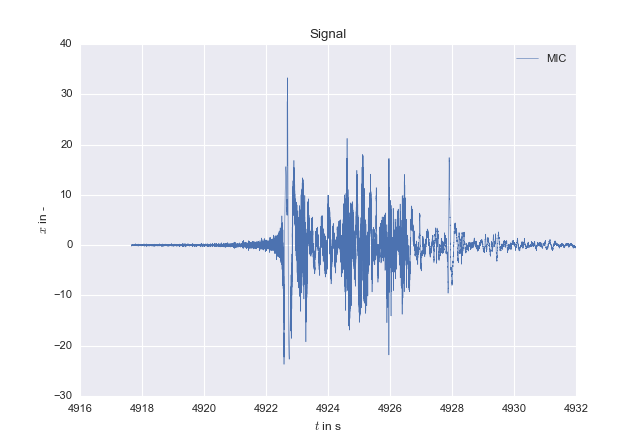

In [18]:
name='MIC'
f, ax = plt.subplots(1)
Signals[name].plot(ax = ax,label = name )
ax.legend()

Wie in der obige Abbildung zu sehen ist hat der signal tieffrequentige Anteile (aufgrund vom Druckwelle der Vorbefahrt). Um diese Effekte zu kann man zwei neue Signale durch filterung erzeugen: 
 
 - bandpass filtered Signal
 -  `A-gewichtete` Signal
 
 

<IPython.core.display.Javascript object>


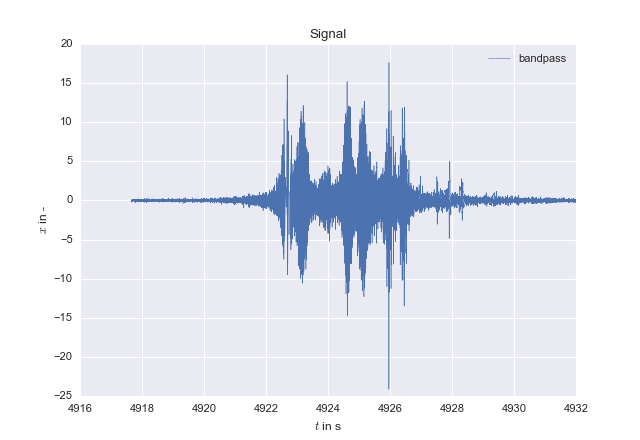

In [19]:
Signals['bandpass']= Signals['MIC'].bandpass(20,20000)
Signals['A']= Signals['bandpass'].weigh('A')
name='bandpass'
f, ax = plt.subplots(1)
Signals[name].plot(ax = ax,label = name )
ax.legend()

### Vergleich von LAF werte 
- für die oben definierte signale (Original, bandpass, A-gewichtet)
- mit FAMOS berechnung

<IPython.core.display.Javascript object>


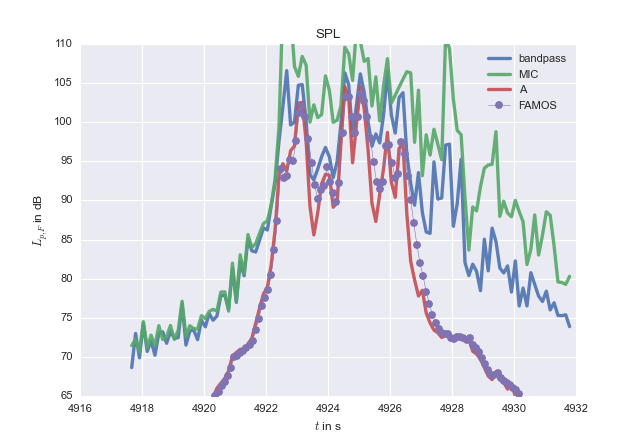

In [20]:
signals = [(sn,key) for key,sn in Signals.items() if not key== 'LS' ]
f,(ax1) = plt.subplots(1)
for (sn,name) in signals:
    sn.plot_levels(ax = ax1, method = 'weighting', label = name,lw=3,alpha=0.9)
LAFi =  np.array(E['LAF']['FAMOS'][1])
ti = np.array(E['LAF']['FAMOS'][0]) + Signals['MIC'].t0
ax1.plot(ti, LAFi ,'-o', label = 'FAMOS' )
_ = ax1.legend()

### Vergleich Spektern 
- für die oben definierte signale (Original, bandpass, A-gewichtet)
- mit FAMOS berechnung

<IPython.core.display.Javascript object>


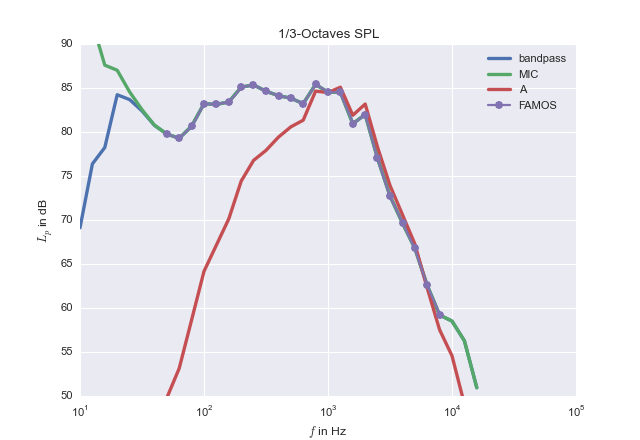

In [21]:
signals = [(sn,key) for key,sn in Signals.items() if key is not 'LS']
f,(ax1) = plt.subplots()
Bands = acoustics.signal.OctaveBand(fstart = 20,fstop=20000, fraction=3)
for sn,name in signals:
    sn.plot_third_octaves(frequencies = Bands.nominal , ax = ax1, lw=3, label = name)
famosSpect =  E['spektrum']['FAMOS']
ax1.plot(famosSpect[0],famosSpect[1] ,'-o', label ='FAMOS', lw = 2 )
_ = ax1.legend()

### Vergleich der Gesamptpegelwerte
Um die Werte, welche mit ``acoustic`` module berechnete wurden, zu plausibilisieren berechnen wir letzlich die Gesamtpegeln in unterschiedlichen weisen, von spektren, direkt und von LAF

In [24]:
Bands = acoustics.signal.OctaveBand(fstart = 50,fstop=8000, fraction=3)
lev = {name:{} for name in Signals.keys() if not name =='LS'}
for (sn,name) in signals:
    d = lev[name]
    d['leq'] = sn.leq()
    d['level'] = sn.levels( method = 'weighting')[1]
    octB= sn.third_octaves(frequencies=Bands.nominal)
    d['Loct'] = level_from_spect(octB[1].leq().T)


1. bandpass: Total levels by:
    - spectrum integration from FAMOS: {{str(np.round(level_from_spect(np.array(E['spektrum']['FAMOS'][1])),3))}} 
    - spectrum integration from Acoustics:  {{str(np.round(lev['bandpass']['Loct'] ,3))}}
    - direct integration from Acoustics: {{str(np.round(lev['bandpass']['leq'],3))}}
    - level integration from Acoustics: {{str(np.round(level_from_LAF(lev['bandpass']['level'], 0.125),3))}}, 
    different since we don't take all frequencies
    
    
2. A: Total levels by 
    - level integration from FAMOS: {{str(np.round(level_from_LAF(np.array(E['LAF']['FAMOS'][1])),3))}} 
    - spectrum integration from Acoustics:  {{str(np.round(lev['A']['Loct'],3)) }}
    - direct integration from Acoustics: {{str(np.round(lev['A']['leq'],3))}}
    - level integration from Acoustics: {{str(np.round(level_from_LAF(lev['A']['level'], 0.125),3))}}

   
## Fazit

den modul acoustics weist gute übereinstimmungen mit FAMOS ein.